In [1]:
pip install mysql-connector-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items') # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='root',
    database='Eecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = r'C:\Users\Hp\Downloads\ecommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector


db = mysql.connector.connect ( host = 'localhost',
                              username = 'root',
                              password = 'root',
                              database = 'Eecommerce' )

                              
cur = db.cursor()                             
                        

## 1. List all unique cities where customers are located.

In [6]:
query  = ''' select distinct customer_city from customers '''

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


## 2. Count the number of orders placed in 2017.

In [8]:
query  = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()

"Total order placed in 2017" ,data[0][0]

('Total order placed in 2017', 180404)

## 3. Find the total sales per category.

In [10]:
query  = """ select upper(products.product_category) category, 
round(sum(payments.payment_value),2) sales
from products join order_items 
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data , columns = ["category" ,"sales"])
df

,category,sales
0,PERFUMERY,24323455.67
1,FURNITURE DECORATION,68648466.81
2,TELEPHONY,23370338.43
3,BED TABLE BATH,82202576.21
4,AUTOMOTIVE,40910127.89
...,...,...
69,CDS MUSIC DVDS,57572.64
70,LA CUISINE,139849.44
71,FASHION CHILDREN'S CLOTHING,37712.16
72,PC GAMER,104372.64


## 4. Calculate the percentage of orders that were paid in installments.

In [12]:
query  = """ select sum(case when payment_installments >= 1
then 1 else 0 end)/ count(*)*100 from payments """

cur.execute(query)

data = cur.fetchall()

"the percentage of orders that were paid in installments is ", data[0][0]

('the percentage of orders that were paid in installments is ',
 Decimal('99.9981'))

## 5. Count the number of customers from each state.

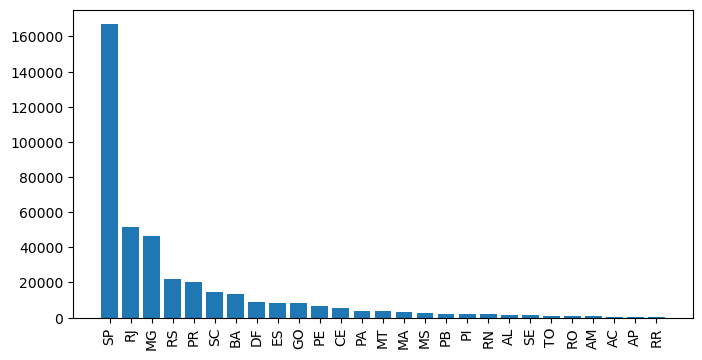

In [14]:
query  = """ select customer_state ,count(customer_id )  from customers 
group by customer_state """

cur.execute(query)

data = cur.fetchall()

 
df = pd.DataFrame(data, columns = [ 'state','customer_count'] )
df = df.sort_values(by = 'customer_count',ascending = False )

plt.figure(figsize = (8,4) )
plt.bar(df['state'],df['customer_count'])
plt.xticks(rotation = 90)
plt.show()


# Intermediate Queries

## 1. Calculate the number of orders per month in 2018.

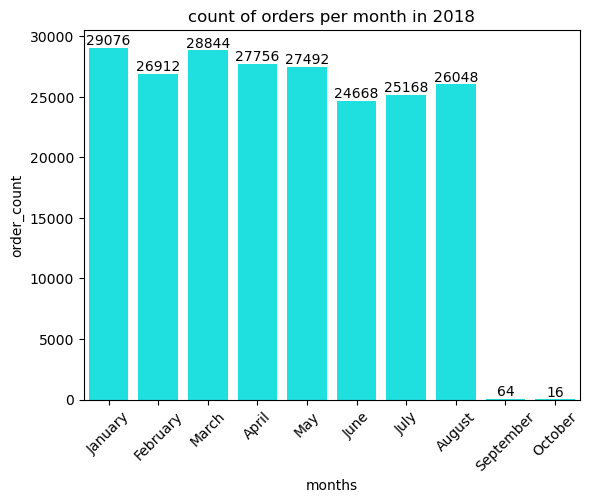

In [17]:
query  = """ select monthname(order_purchase_timestamp) months , 
count(order_id) order_count from orders
where year(order_purchase_timestamp) = 2018
group by months """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data ,columns = ['months','order_count'])
o = ['January','February','March','April','May','June','July','August','September','October']

ax = sns.barplot(x = df['months'], y = df['order_count'] , data = df ,order = o, color = 'cyan')
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.title('count of orders per month in 2018')
plt.show()

## 2. Find the average number of products per order, grouped by customer city.

In [19]:
query  = """ with count_per_order as
(select orders.order_id , orders.customer_id ,
count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id , orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data , columns= ['customer city','average_orders'])
df.head()

,customer city,average_orders
0,padre carvalho,84.00
1,celso ramos,78.00
2,datas,72.00
3,candido godoi,72.00
4,matias olimpio,60.00


## 3. Calculate the percentage of total revenue contributed by each product category.

In [21]:
query  = """ select products.product_category category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales
from products join order_items 
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category
order by sales desc ;"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data , columns= ['category','sales'])
df.head()

,category,sales
0,bed table bath,128.37
1,HEALTH BEAUTY,124.23
2,computer accessories,118.83
3,Furniture Decoration,107.20
4,Watches present,107.13


##  4. Identify the correlation between product price and the number of times a product has been purchased.

In [23]:
import numpy as np
query  = """ select products.product_category ,
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id 
group by products.product_category """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data , columns= ['category','order_count','price'])
ar1 = df['order_count']
ar2 = df['price']

a = np.corrcoef([ar1,ar2])
print('the correlation between product price and the number of times a product has been purchased', a[0][-1])

the correlation between product price and the number of times a product has been purchased -0.1063151416715756


## 5. Calculate the total revenue generated by each seller, and rank them by revenue.

In [25]:
query  = """ select * , dense_rank() over(order by revenue desc ) from
(select order_items.seller_id,
sum(payments.payment_value)  revenue 
from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id ) as a  """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data , columns=['seller_id','revenue','rank'])
df.head()


,seller_id,revenue,rank
0,7c67e1448b00f6e969d365cea6b010ab,6.086003e+06,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,3.698664e+06,2
2,4a3ca9315b744ce9f8e9374361493884,3.614943e+06,3
3,1f50f920176fa81dab994f9023523100,3.483041e+06,4
4,53243585a1d6dc2643021fd1853d8905,3.418837e+06,5


#  Advanced Queries

##  1. Calculate the moving average of order values for each customer over their order history.

In [45]:
query  = """select customer_id , order_purchase_timestamp, payment ,
avg(payment) over(partition by customer_id order by order_purchase_timestamp 
rows between 2 preceding and current row ) as mov_avg
from 
(select orders.customer_id , orders.order_purchase_timestamp , payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id ) as a """
cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
...,...,...,...,...
1662171,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
1662172,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
1662173,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
1662174,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


# 2. Calculate the cumulative sales per month for each year.

In [48]:
query = """ select years , months ,payment, sum(payment) 
over( order by years , months )  cumulative_sales  from(
select year(order_purchase_timestamp) as years,
month(order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years , months order by years , months ) as a """
cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data)
df


,0,1,2,3
0,2016,9,4035.84,4.035840e+03
1,2016,10,945447.68,9.494835e+05
2,2016,12,313.92,9.497974e+05
3,2017,1,2215808.64,3.165606e+06
4,2017,2,4670528.15,7.836134e+06
5,2017,3,7197817.59,1.503395e+07
6,2017,4,6684608.47,2.171856e+07
7,2017,5,9486701.12,3.120526e+07
8,2017,6,8180422.09,3.938568e+07
9,2017,7,9478126.71,4.886381e+07


# 3. Calculate the year-over-year growth rate of total sales.

In [58]:
query = """with a as (select year(order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years  order by years )
select years ,( ( payment - lag(payment, 1) over(order by years)) / 
lag(payment, 1) over(order by years) ) * 100 from a """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data , columns = ["years","yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703758
2,2018,20.000924


# 4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

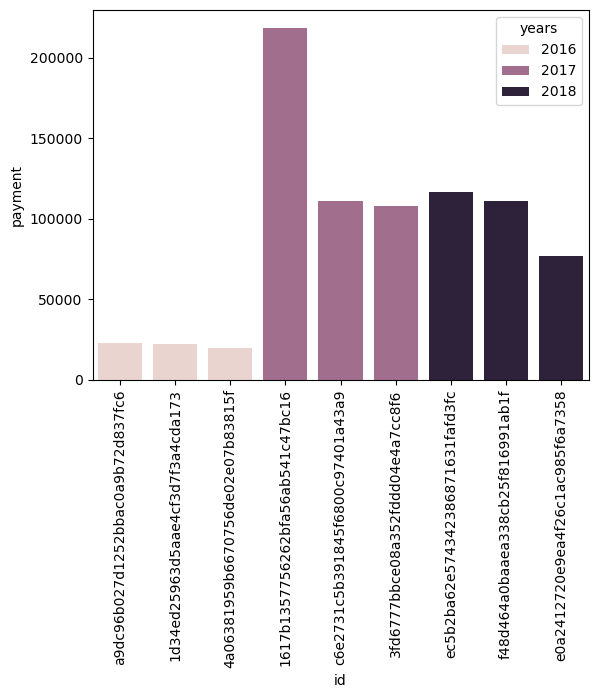

In [62]:
query = """ select years , customer_id , payment , d_rank from 
(select year(orders.order_purchase_timestamp) years , 
orders.customer_id ,
sum(payments.payment_value) payment,
dense_rank() over (partition by year(orders.order_purchase_timestamp) 
order by sum(payments.payment_value) desc ) d_rank
from orders join payments 
on payments.order_id = orders.order_id 
group by year(orders.order_purchase_timestamp),
orders.customer_id ) as a 
where d_rank <=3 """
cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data , columns = ["years","id","payment","rank"])
sns.barplot(x = "id" , y = "payment", data= df , hue = "years" )
plt.xticks(rotation = 90)
plt.show()